In [86]:
from SimuSamp.new_funcs.load.SpatDat import SpatDat
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from SimuSamp.new_funcs.compute.n_core_sampler import sample_n_cores
from SimuSamp.new_funcs.compute.hopkins_stat import hopkins_stat
from SimuSamp.new_funcs.compute.n_neighbours import neighbours
import pingouin as pg
from astropy.stats import RipleysKEstimator
from scipy.interpolate import interp1d
import scipy.stats as stats
import ast
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
from shapely.geometry import Polygon, Point
import geopandas as gpd
import alphashape.alphashape as alphashape
import pointpats
import itertools

In [2]:
# parent_filepath = "C:/Users/Michael/Desktop/block_data"
parent_filepath = "../../../../Simulated WS Sampling/block_data"
outpath = "../../../../Data/Plots/Ripleys/Clusters"
sampleids = ["01_F", "01_G", "02_G", "02_H", "03_B", "03_H", "04_I", "04_N", "05_G", "05_I", "06_H", "07_K", "08_J", "09_E", "10_B", "11_E", "11_F", "12_M", "13_G", "14_I", "15_G", "16_B", "17_I", "18_E", "19_F", "21_I", "22_N", "23_B", "24_I", "25_M", "26_I", "27_H", "28_FSC", "29_L", "30_D"]
microns_per_pixel=0.22715
mm2_per_pixels2 = (microns_per_pixel / 1000) ** 2

font_dict = {"fontsize": 10, "fontweight": "bold", "fontname": "Arial"}
font_dict_major = {"fontsize": 16, "fontweight": "bold", "fontname": "Arial"}

In [ ]:
clin = pd.read_excel("../../../../Data/ClinicalData_8.24.2020_DW.xlsx")

clin = clin.rename(columns={"Age at Specimen Collection (Years)": "Age"})

clin["Subject ID"] = clin["Subject ID"].astype(str).str.lstrip("0")

## WS Stats

In [3]:
samples = []
annotation = []
hopkins = []
n_neighbour = []
densities = []
areas = []
for sample in sampleids:
    data = SpatDat(sample, parent_filepath)
    for region in ["tumour", "IM", "outer_IM"]:
        cells = data.subset_cells(region)
        nn = np.nanmean(neighbours(cells, 1))

        anno = data.subset_annotation(region)
        area = anno.area * mm2_per_pixels2

        hopkins_statistic = hopkins_stat(anno, cells)
        
        den = len(cells) / (area)

        samples.append(sample)
        annotation.append(region)
        densities.append(den)
        areas.append(area)
        hopkins.append(hopkins_statistic)
        n_neighbour.append(nn)


ws_stats = pd.DataFrame({"sample": samples,
                         "annotation": annotation,
                         "density": densities,
                         "area_mm": areas,
                         "hopkins": hopkins,
                         "n_neighbour": n_neighbour
                         })

ws_stats.to_excel("../../../../Data/WS_stats.xlsx", index=False)

In [46]:
ws_stats = pd.read_excel("../../../../Data/WS_stats.xlsx")
ws_stats["Subject ID"] = ws_stats["sample"].str.split("_").str[0]
ws_stats["Subject ID"] = ws_stats["Subject ID"].astype(str).str.lstrip("0")

ws_stats = ws_stats.merge(clin[["Subject ID", "OS", "Death", "Sex", "Race", "Age"]], on="Subject ID", how="left")

ws_stats.to_excel("../../../../Data/WS_stats.xlsx", index=False)

In [47]:
ws_stats = pd.read_excel("../../../../Data/WS_stats.xlsx")
ws_stats

,sample,annotation,density,area_mm,hopkins,n_neighbour,Subject ID,OS,Death,Sex,Race,Age
0,01_F,tumour,804.022884,198.490619,0.536679,14.494250,1,83.225806,1,F,B,64
1,01_F,IM,815.782184,68.195900,0.542729,15.130418,1,83.225806,1,F,B,64
2,01_F,outer_IM,962.356591,25.719157,0.538139,14.607300,1,83.225806,1,F,B,64
3,01_G,tumour,225.027071,29.463122,0.564916,23.102434,1,83.225806,1,F,B,64
4,01_G,IM,212.653527,35.729480,0.607533,21.936455,1,83.225806,1,F,B,64
...,...,...,...,...,...,...,...,...,...,...,...,...
100,29_L,IM,310.231821,73.918916,0.565996,20.634262,29,47.806452,1,M,W,73
101,29_L,outer_IM,439.448216,46.328553,0.565720,19.221330,29,47.806452,1,M,W,73
102,30_D,tumour,122.400520,7.581667,0.582900,34.977897,30,1.266667,1,M,W,48
103,30_D,IM,673.056746,33.940675,0.569711,14.943522,30,1.266667,1,M,W,48


## Ripley's L and H Functions

In [3]:
def get_distances(max_dist=5000, n_steps=50, microns_per_pixel=0.22715):
    # Calculate distances for L function
    distances = np.linspace(0, max_dist / microns_per_pixel, n_steps)

    # Calculate complete spatial randomness (CSR) for Poisson process
    poisson_csr = np.pi * distances ** 2

    return distances, poisson_csr

In [4]:
def ripley_k(spatdat, region, distances, mode="ripley", frac=0.1):

    # Get cells and annotations ======================================
    cells = spatdat.subset_cells(region)
    anno = spatdat.subset_annotation(region)
    # ================================================================

    # Randomly sample 10% of cells for computation ===================
    n_sample = int(len(cells) * frac)
    coords = np.array([(p.x, p.y) for p in cells.sample(n_sample).geometry])
    # ================================================================

    # Define analysis bounds ==========================================
    x_min, y_min, x_max, y_max = anno.bounds
    kest_anno = RipleysKEstimator(area=anno.area, x_max=x_max, y_max=y_max, x_min=x_min, y_min=y_min)
    # =================================================================
    
    # Calculate L function for tumour and IM regions
    k_data = kest_anno(data=coords, radii=distances, mode=mode)

    return k_data

In [5]:
def edge_correction_weight(point, r, analysis_area):
    # Get fraction of the buffer within the analysis area
    circle = point.buffer(r)
    intersected_area = analysis_area.intersection(circle).area
    if r <= 0:
        weight = 0
    else:
        weight = intersected_area / circle.area
    
    return weight

In [6]:
def compute_Hr_per_point(gdf, analysis_area, distances):
    
    h_values = {r: [] for r in distances}

    area = analysis_area.area

    tree = KDTree([[p.x, p.y] for p in gdf.geometry])

    for point in gdf.geometry:
        xi, yi = point.x, point.y
        dists, _ = tree.query([point.x, point.y], k=len(gdf), distance_upper_bound=max(distances))
        # Exclude self-distance
        dists = dists[np.isfinite(dists) & (dists > 0)]
        
        for r in distances:
            count = np.sum(dists <= r)

            # Apply edge correction
            weight = edge_correction_weight(point, r, analysis_area)

            # Adjusted density
            lambda_hat = len(gdf) / area

            if r <= 0:
                h_values[r].append(0)
            else:
                # Corrected K function
                k_r = (count / lambda_hat) / weight
                l_r = np.sqrt(k_r / np.pi)
                h_r = l_r - r
                h_values[r].append(h_r)
    
    h_function = pd.DataFrame(h_values)

    return h_function

In [7]:
def hr_point_noedgecorrection(gdf_cells, analysis_area, distances, gdf_points=None):

    if gdf_points is None:
        gdf_points = gdf_cells

    h_values = {r: [] for r in distances}
    area = analysis_area.area
    tree = KDTree([[p.x, p.y] for p in gdf_cells.geometry])

    for point in gdf_points.geometry:
        dists, _ = tree.query([point.x, point.y], k=len(gdf_cells), distance_upper_bound=max(distances))
        # Exclude self-distance
        dists = dists[np.isfinite(dists) & (dists > 0)]

        for r in distances:
            
            count = np.sum(dists <= r)
            
            # Adjusted density
            lambda_hat = len(gdf_cells) / area
            
            # Approximate K function
            k_r = count / lambda_hat
            
            l_r = np.sqrt(k_r / np.pi)
            h_r = l_r - r
            h_values[r].append(h_r)
    
    h_function = pd.DataFrame(h_values)

    return h_function

In [8]:
def ripley_clusters(h_data, cells, outpath, sampleid, region, distances, microns_per_pixel=0.22715, points=False, min_size=0.2):

    if points:
        points_text = "randpoints"
    else:
        points_text = "cells"

    if points:
        # Get points where H(r) > 0 at low r values
        clust_points = cells.iloc[h_data[h_data.iloc[:, 2] <= 0].index]
        not_clust_points = cells.iloc[h_data[h_data.iloc[:, 2] > 0].index]
    else:
        # Get points where H(r) > 0 at low r values
        clust_points = cells.iloc[h_data[h_data.iloc[:, 2] > 0].index]
        not_clust_points = cells.iloc[h_data[h_data.iloc[:, 2] <= 0].index]

    # Get length of major axis for each cluster ======================
    clust_shape = alphashape(clust_points, 0.003)

    if isinstance(clust_shape, Polygon):
        gdf = gpd.GeoDataFrame(geometry=[clust_shape])
    else:
        gdf = gpd.GeoDataFrame(geometry=[geom for geom in clust_shape.geoms])

    gdf["area"] = gdf.area

    gdf["box"] = gdf.minimum_rotated_rectangle()

    gdf = gdf[gdf["box"].notnull()]

    if len(gdf) == 0:
        return None

    gdf["box_x"], gdf["box_y"] = zip(*gdf["box"].apply(lambda poly: poly.exterior.coords.xy))

    max_len = []
    min_len = []
    for idx, row in gdf.iterrows():
        edge_lengths = [Point((row["box_x"][0], row["box_y"][0])).distance(Point((row["box_x"][1], row["box_y"][1]))),
                        Point((row["box_x"][1], row["box_y"][1])).distance(Point((row["box_x"][2], row["box_y"][2]))),
                        Point((row["box_x"][2], row["box_y"][2])).distance(Point((row["box_x"][3], row["box_y"][3]))),
                        Point((row["box_x"][3], row["box_y"][3])).distance(Point((row["box_x"][0], row["box_y"][0])))]
        max_len.append(max(edge_lengths))
        min_len.append(min(edge_lengths))

    gdf["max_len"] = max_len
    gdf["min_len"] = min_len
    # ================================================================

    # Plot cluster areas ============================================
    plt.cla()
    plt.clf()
    plt.close()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot Unfiltered Clusters
    axes[0].hist(gdf["area"] * mm2_per_pixels2, bins=50)
    axes[0].axvline(min_size, color="red", linestyle="--", label=f"{min_size} mm\u00b2")

    axes[0].legend(prop={"size": 10, "weight": "bold", "family": "Arial"})


    axes[0].set_xlabel("Cluster area (mm\u00b2)", fontdict=font_dict)
    axes[0].set_ylabel("Frequency", fontdict=font_dict)
    axes[0].set_title("Cluster Area Distribution", fontdict=font_dict)

    # Plot Filtered Clusters
    gdf_filt = gdf[gdf["area"] * mm2_per_pixels2 > min_size]

    axes[1].hist(gdf_filt["area"] * mm2_per_pixels2, bins=50)
    axes[1].axvline(min_size, color="red", linestyle="--", label=f"{min_size} mm\u00b2")

    axes[1].legend(prop={"size": 10, "weight": "bold", "family": "Arial"})

    axes[1].set_xlabel("Cluster area (mm\u00b2)", fontdict=font_dict)
    axes[1].set_ylabel("Frequency", fontdict=font_dict)
    axes[1].set_title("Filtered Cluster Area Distribution", fontdict=font_dict)

    # Plot Major Axis Length Distribution
    axes[2].hist(gdf_filt["max_len"] * microns_per_pixel, bins=50)

    axes[2].set_xlabel("Major Axis Length (µm)", fontdict=font_dict)
    axes[2].set_ylabel("Frequency", fontdict=font_dict)
    axes[2].set_title("Filtered Cluster Length Distribution", fontdict=font_dict)

    fig.suptitle(f"{region} Cluster Filtering for {sampleid}: {points_text}", fontweight="bold", fontname="Arial", fontsize=16)

    plt.savefig(f"{outpath}/{sampleid}_{region}_cluster_filtering_{points_text}.png", dpi=600, transparent=True, bbox_inches="tight")
    # ================================================================

    # Plot cluster annotations =======================================
    plt.cla()
    plt.clf()
    plt.close()

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    # Plot all points
    not_clust_points.plot(markersize=0.01, color="red", ax=axes[0])
    clust_points.plot(markersize=0.01, color="blue", ax=axes[0])
    axes[0].set_aspect("equal")
    axes[0].set_axis_off()
    axes[0].invert_yaxis()
    axes[0].set_title("All Cells", fontdict=font_dict)

    # Plot Clusters
    clust_points.plot(markersize=0.01, color="blue", ax=axes[1])
    gdf.plot(color="None", edgecolor="black", linewidth=0.5, ax=axes[1])
    axes[1].set_aspect("equal")
    axes[1].set_axis_off()
    axes[1].invert_yaxis()
    axes[1].set_title("Clusters", fontdict=font_dict)

    # Plot Cluster Bounds
    clust_points.plot(markersize=0.1, color="blue", ax=axes[2])
    gdf.plot(color="None", edgecolor="black", linewidth=0.5, ax=axes[2])
    gdf.minimum_rotated_rectangle().plot(color="None", edgecolor="red",  linewidth=0.5, ax=axes[2])
    axes[2].set_aspect("equal")
    axes[2].set_axis_off()
    axes[2].invert_yaxis()
    axes[2].set_title("Cluster Bounds", fontdict=font_dict)

    # Plot Filtered Clusters
    filt_cells = gpd.sjoin(clust_points, gdf_filt, predicate="within")

    filt_cells.plot(markersize=0.1, color="blue", ax=axes[3])
    gdf_filt.plot(color="None", edgecolor="black", linewidth=0.5, ax=axes[3])
    gdf_filt["box"].plot(color="None", edgecolor="red", linewidth=0.5, ax=axes[3])
    axes[3].set_aspect("equal")
    axes[3].set_axis_off()
    axes[3].invert_yaxis()
    axes[3].set_title("Filtered Clusters", fontdict=font_dict)

    fig.suptitle(f"{region} Cluster Filtering for {sampleid}: {points_text}", fontweight="bold", fontname="Arial", fontsize=16)

    plt.savefig(f"{outpath}/{sampleid}_{region}_filtered_clusters_{points_text}.png", dpi=600, transparent=True, bbox_inches="tight")
    # =================================================================

    # Ripley's H function
    plt.cla()
    plt.clf()
    plt.close()

    plt.plot(distances * microns_per_pixel, h_data[h_data.iloc[:, 2] > 0].mean(axis=0), color="blue", label="Clustered")
    plt.plot(distances * microns_per_pixel, h_data[h_data.iloc[:, 2] <= 0].mean(axis=0), color="orange", label="Not Clustered")
    plt.plot(distances * microns_per_pixel, h_data.mean(axis=0), color="green", label="Total")
    plt.axhline(0, color="red", linestyle="--")

    plt.xlabel("Distance (\u00b2m)", fontdict=font_dict)
    plt.ylabel("H(r)", fontdict=font_dict)

    plt.legend(prop={"size": 10, "weight": "bold", "family": "Arial"})

    plt.title(f"{region} H(r) for {sampleid}: {points_text}", fontdict=font_dict_major)

    plt.savefig(f"{outpath}/{sampleid}_{region}_ripley_H_{points_text}.png", dpi=600, transparent=True, bbox_inches="tight")

    plt.cla()
    plt.clf()
    plt.close()

    gdf["sampleid"] = sampleid
    gdf["region"] = region
    gdf["points"] = points_text

    return gdf

In [9]:
def get_intercept(k_data, distances, poisson_csr, microns_per_pixel=0.22715, intercept=0.0):

    # Interpolate intercept of L Function with with CSR
    interp = interp1d(((k_data[1:] / np.pi) ** 0.5 - distances[1:]) * microns_per_pixel, distances[1:] * microns_per_pixel, kind="nearest")

    intercept = interp(intercept)

    return intercept

In [10]:
def plot_ripley_l(k_data, distances, intercept, microns_per_pixel=0.22715):

    # Plot L Function
    plt.plot(distances * microns_per_pixel, ((k_data / np.pi) ** 0.5)  * microns_per_pixel, color="black", label="Observed Cell Distribution")

    # Plot CSR
    plt.plot(distances * microns_per_pixel, distances * microns_per_pixel, color="red", linestyle="--", label="Random Distribution")

    plt.ylim(0, 5000)
    plt.xlim(0, 5000)

    plt.gca().set_aspect("equal")

    # Plot intercept of k Function with CSR ===========================
    # Convert y-values to proportion of the y-axis
    ymax = (intercept - plt.gca().get_ylim()[0]) / (plt.gca().get_ylim()[1] - plt.gca().get_ylim()[0])

    plt.axvline(x=intercept, color="gainsboro", linestyle="--", label=f"Intercept: {int(intercept)} \u00b5m", ymax=ymax, zorder=0)
    # =================================================================

    # Stylize plot ====================================================
    plt.xlabel("Radius (\u00b5m)", fontdict=font_dict)
    plt.ylabel("L(r)", fontdict=font_dict)

    plt.xticks(fontname="Arial", fontsize=10);
    plt.yticks(fontname="Arial", fontsize=10);

    plt.legend(prop={"size": 10, "family": "Arial"})
    # =================================================================

In [11]:
def plot_ripley_h(k_data, distances, intercept, microns_per_pixel=0.22715):

    # Plot H Function
    plt.plot(distances * microns_per_pixel, ((k_data / np.pi) ** 0.5 - distances) * microns_per_pixel, color="black", label="Observed Cell Distribution")

    # Plot CSR
    plt.axhline(y=1.0, color="red", linestyle="--", label="Random Distribution")

    plt.xlim(0, 5000)

    # Plot intercept of H Function with CSR ===========================
    # Convert y-values to proportion of the y-axis
    ymax = (0.0 - plt.gca().get_ylim()[0]) / (plt.gca().get_ylim()[1] - plt.gca().get_ylim()[0])

    plt.axvline(x=intercept, color="gainsboro", linestyle="--", label=f"Intercept: {int(intercept)} \u00b5m", ymax=ymax, zorder=0)
    # =================================================================

    # Stylize plot ====================================================
    plt.xlabel("Radius (\u00b5m)", fontdict=font_dict)
    plt.ylabel("H(r)", fontdict=font_dict)

    plt.xticks(fontname="Arial", fontsize=10);
    plt.yticks(fontname="Arial", fontsize=10);

    plt.legend(prop={"size": 10, "family": "Arial"})
    # =================================================================

### Plot Per Sample

In [ ]:
sample_list = []
region_list = []
intercept_list = []
k_data_list = []
for sampleid in sampleids:

    spatdat = SpatDat(sampleid, parent_filepath)

    for region in ["tumour", "outer_IM"]:

            distances, poisson_csr = get_distances(5000, 50)

            k_data = ripley_k(spatdat, region, distances, "ripley", frac=0.1)

            data_list = []
            for i in range(50):
                k_data = ripley_k(spatdat, region, distances, "ripley", frac=0.1)
                data_list.append(k_data)
            
            k_data = np.mean(data_list, axis=0)

            intercept = get_intercept(k_data, distances, poisson_csr)

            sample_list.append(sampleid)
            region_list.append(region)
            intercept_list.append(intercept)
            k_data_list.append(k_data)

            # Plot L Function
            plt.cla()
            plt.clf()
            plt.close()

            fig, ax = plt.subplots(figsize=(4, 4))

            plot_ripley_l(k_data, distances, intercept)

            for data in data_list:
                plt.plot(distances * microns_per_pixel, ((data / np.pi) ** 0.5) * microns_per_pixel, color="black", alpha=0.1, zorder=0)

            # Stylize plot
            plt.title(f"Ripley's L Function\n{region}: {sampleid}", fontdict=font_dict)

            plt.savefig(f"../../../../Data/Plots/Ripleys/{sampleid}_{region}_KFunction.png", dpi=300, transparent=True, bbox_inches="tight")

            # Plot H Function
            plt.cla()
            plt.clf()
            plt.close()

            fig, ax = plt.subplots(figsize=(4, 4))

            for data in data_list:
                plt.plot(distances * microns_per_pixel, ((data / np.pi) ** 0.5 - distances) * microns_per_pixel, color="black", alpha=0.1, zorder=0)

            plot_ripley_h(k_data, distances, intercept)

            # Stylize plot
            plt.title(f"Ripley's H Function\n{region}: {sampleid}", fontdict=font_dict)

            plt.savefig(f"../../../../Data/Plots/Ripleys/{sampleid}_{region}_HFunction.png", dpi=300, transparent=True, bbox_inches="tight")

In [11]:
ripley_stats = pd.DataFrame({"sample": sample_list,
                             "region": region_list,
                             "intercept": intercept_list,
                             "k_data": k_data_list
                             })

ripley_stats.to_excel("../../../../Data/Ripley_stats.xlsx", index=False)

## Plot Summary Statistics

In [12]:
ripley_stats = pd.read_excel("../../../../Data/Ripley_stats.xlsx")

ripley_stats["k_data"] = [np.array(ast.literal_eval(x.replace("\n", "").replace(" ", ","))) for x in ripley_stats["k_data"]]

In [13]:
ripley_tum = ripley_stats[ripley_stats["region"] == "tumour"].reset_index(drop=True)
ripley_im = ripley_stats[ripley_stats["region"] == "outer_IM"].reset_index(drop=True)

### Plot Summary L and H Functions

In [14]:
distances, poisson_csr = get_distances(5000, 50)

ripley_tum_mean = np.mean(ripley_tum["k_data"], axis=0)
ripley_im_mean = np.mean(ripley_im["k_data"], axis=0)

tum_int = get_intercept(ripley_tum_mean, distances, poisson_csr)
im_int = get_intercept(ripley_im_mean, distances, poisson_csr)

#### L Function

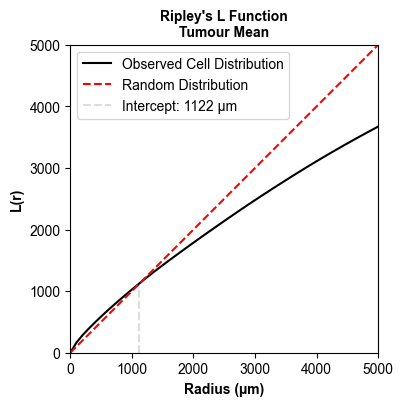

In [14]:
# Plot Tumour L Function

fig, ax = plt.subplots(figsize=(4, 4))

# Plot Mean L Function
plot_ripley_l(ripley_tum_mean, distances, tum_int)

# Stylize plot
plt.title(f"Ripley's L Function\nTumour Mean", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/Ripleys/allsamples_tumour_LFunction.png", dpi=300, transparent=True, bbox_inches="tight")

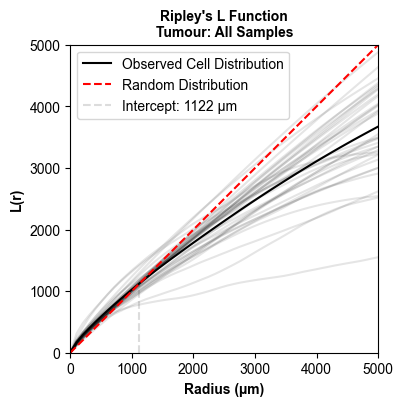

In [15]:
# Plot Tumour L Function

fig, ax = plt.subplots(figsize=(4, 4))

# Plot Mean L Function
plot_ripley_l(ripley_tum_mean, distances, tum_int)

# Plot individual L Functions
for data in ripley_tum["k_data"]:
    plt.plot(distances * microns_per_pixel, ((data / np.pi) ** 0.5) * microns_per_pixel, color="black", alpha=0.1, zorder=0)

# Stylize plot
plt.title(f"Ripley's L Function\nTumour: All Samples", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/Ripleys/allsamples_plotted_tumour_LFunction.png", dpi=300, transparent=True, bbox_inches="tight")

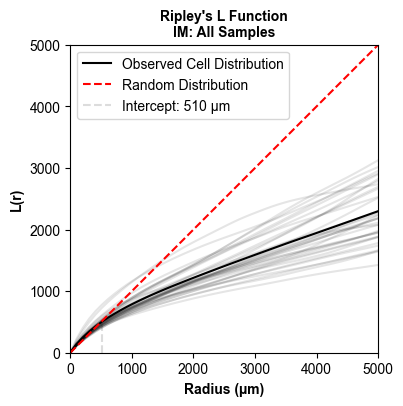

In [16]:
# Plot IM L Function

fig, ax = plt.subplots(figsize=(4, 4))

# Plot Mean L Function
plot_ripley_l(ripley_im_mean, distances, im_int)

# Plot individual L Functions
for data in ripley_im["k_data"]:
    plt.plot(distances * microns_per_pixel, ((data / np.pi) ** 0.5) * microns_per_pixel, color="black", alpha=0.1, zorder=0)

# Stylize plot
plt.title(f"Ripley's L Function\nIM: All Samples", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/Ripleys/allsamples_plotted_IM_LFunction.png", dpi=300, transparent=True, bbox_inches="tight")

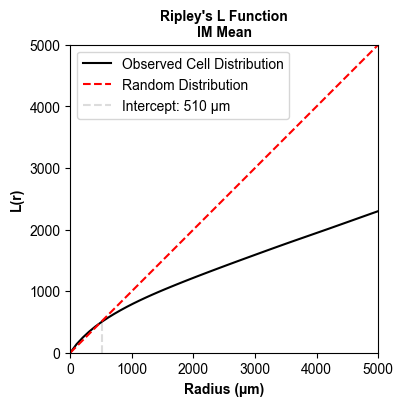

In [17]:
# Plot IM L Function

fig, ax = plt.subplots(figsize=(4, 4))

# Plot Mean L Function
plot_ripley_l(ripley_im_mean, distances, im_int)

# Stylize plot
plt.title(f"Ripley's L Function\nIM Mean", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/Ripleys/allsamples_IM_LFunction.png", dpi=300, transparent=True, bbox_inches="tight")

#### H Function

In [37]:
tum_max = max(((ripley_tum_mean / np.pi) ** 0.5 - distances) * microns_per_pixel)

In [38]:
get_intercept(ripley_tum_mean, distances, poisson_csr, intercept=tum_max)

array(306.12244898)

In [39]:
im_max = max(((ripley_im_mean / np.pi) ** 0.5 - distances) * microns_per_pixel)

In [40]:
get_intercept(ripley_im_mean, distances, poisson_csr, intercept=im_max)

array(204.08163265)

Text(0.5, 1.0, "Ripley's H Function\nTumour Mean")

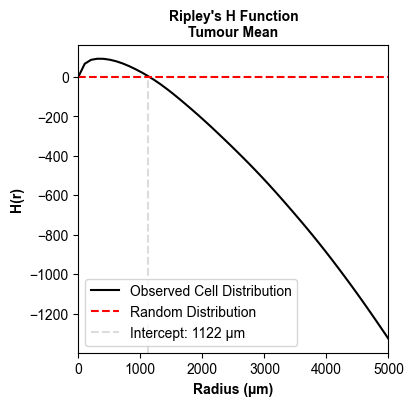

In [13]:
# Plot Tumour H Function

fig, ax = plt.subplots(figsize=(4, 4))

# Plot Mean H Function
plot_ripley_h(ripley_tum_mean, distances, tum_int)

# Stylize plot
plt.title(f"Ripley's H Function\nTumour Mean", fontdict=font_dict)

# plt.savefig(f"../../../../Data/Plots/Ripleys/allsamples_tumour_HFunction.png", dpi=300, transparent=True, bbox_inches="tight")

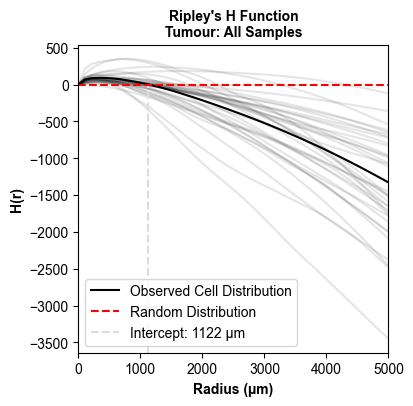

In [19]:
# Plot Tumour H Function

fig, ax = plt.subplots(figsize=(4, 4))

# Plot individual L Functions
for data in ripley_tum["k_data"]:
    plt.plot(distances * microns_per_pixel, ((data / np.pi) ** 0.5 - distances) * microns_per_pixel, color="black", alpha=0.1, zorder=0)

# Plot Mean H Function
plot_ripley_h(ripley_tum_mean, distances, tum_int)

# Stylize plot
plt.title(f"Ripley's H Function\nTumour: All Samples", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/Ripleys/allsamples_plotted_tumour_HFunction.png", dpi=300, transparent=True, bbox_inches="tight")

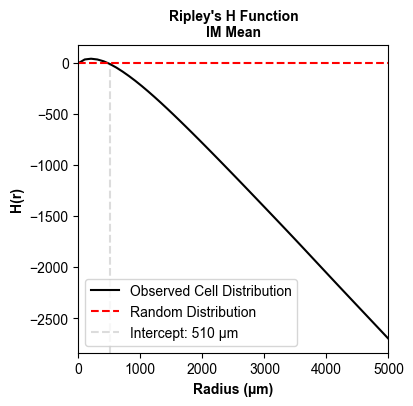

In [20]:
# Plot IM H Function

fig, ax = plt.subplots(figsize=(4, 4))

# Plot Mean H Function
plot_ripley_h(ripley_im_mean, distances, im_int)

# Stylize plot
plt.title(f"Ripley's H Function\nIM Mean", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/Ripleys/allsamples_IM_HFunction.png", dpi=300, transparent=True, bbox_inches="tight")

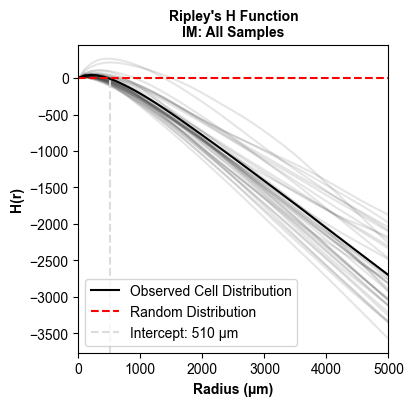

In [21]:
# Plot IM H Function

fig, ax = plt.subplots(figsize=(4, 4))

# Plot individual L Functions
for data in ripley_im["k_data"]:
    plt.plot(distances * microns_per_pixel, ((data / np.pi) ** 0.5 - distances) * microns_per_pixel, color="black", alpha=0.1, zorder=0)

# Plot Mean H Function
plot_ripley_h(ripley_im_mean, distances, im_int)

# Stylize plot
plt.title(f"Ripley's H Function\nIM: All Samples", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/Ripleys/allsamples_plotted_IM_HFunction.png", dpi=300, transparent=True, bbox_inches="tight")

### Plot CSR Intercept Distances for Tumour and IM

In [11]:
res = stats.wilcoxon(ripley_tum["intercept"], ripley_im["intercept"])

C:\Users\Michael\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


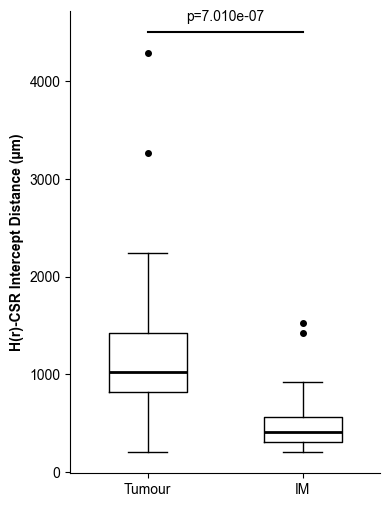

In [ ]:
fig, ax = plt.subplots(figsize=(4, 6))

positions = [0, 0.6]

plt.boxplot([ripley_tum["intercept"], ripley_im["intercept"]], positions=positions, widths=0.3, tick_labels=["Tumour", "IM"], flierprops={"marker": "o", "markersize": 4, "markerfacecolor": "black"}, medianprops={"color": "black", "linewidth": 2});

xmin = -0.3
xmax = 0.9
plt.xlim(xmin, xmax)

x_min, x_max = [(x - xmin) / (xmax - xmin) for x in positions]

plt.axhline(y=ripley_stats["intercept"].max() * 1.05, color="black", xmin=x_min, xmax=x_max)
plt.text(x=0.3, y=ripley_stats["intercept"].max() * 1.07, s=f"p={res.pvalue:.3e}", ha="center", va="bottom", fontsize=10, fontname="Arial")

plt.ylabel("H(r)-CSR Intercept Distance (\u00b5m)", fontdict=font_dict);

plt.xticks(fontname="Arial", fontsize=10);
plt.yticks(fontname="Arial", fontsize=10);

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("../../../../Data/Plots/Ripleys/Intercept_Boxplot.png", dpi=300, transparent=True, bbox_inches="tight")

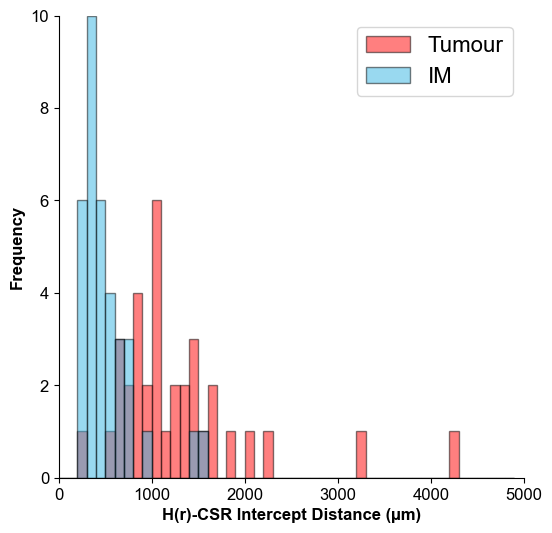

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))

bin_width = 100
bins = np.arange(0, 5000, bin_width)

plt.hist(ripley_tum["intercept"], bins=bins, color="red", alpha=0.5, label="Tumour", edgecolor="black", linewidth=1)

plt.hist(ripley_im["intercept"], bins=bins, color=(52/255, 181/255, 227/255), alpha=0.5, label="IM", edgecolor="black", linewidth=1)

plt.xlabel("H(r)-CSR Intercept Distance (\u00b5m)", fontdict={"fontsize": 12, "fontname": "Arial", "fontweight": "bold"})
plt.ylabel("Frequency", fontdict={"fontsize": 12, "fontname": "Arial", "fontweight": "bold"})

# plt.axvline(x=ripley_tum["intercept"].mean(), color="red", linestyle="--", label=f"Tumour Mean: {int(ripley_tum['intercept'].mean())} \u00b5m")

# plt.axvline(x=ripley_im["intercept"].mean(), color=(52/255, 181/255, 227/255), linestyle="--", label=f"IM Mean: {int(ripley_im['intercept'].mean())} \u00b5m")

plt.xlim(0, 5000)
plt.ylim(0, 10)

plt.xticks(fontname="Arial", fontsize=12)
plt.yticks(fontname="Arial", fontsize=12)

plt.legend(prop={"size": 16, "family": "Arial"})

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("../../../../Data/Plots/Ripleys/Intercept_Histogram.png", dpi=300, transparent=True, bbox_inches="tight")

## Ripley's H Clustering

In [15]:
distances, poisson_csr = get_distances(5000, 50)

filtered_clusters = []

for sampleid in sampleids:
    
    spatdat = SpatDat(sampleid, parent_filepath)

    for region in ["tumour", "outer_IM"]:

        cells = spatdat.subset_cells(region)

        cells = cells.sample(int(0.1 * len(cells))).reset_index(drop=True)

        anno = spatdat.subset_annotation(region)

        h_data = hr_point_noedgecorrection(cells, anno, distances)

        gdf_filt = ripley_clusters(h_data, cells, outpath, sampleid, region, distances, points=False, min_size=0.00)

        filtered_clusters.append(gdf_filt)

C:\Users\Michael\AppData\Local\Temp\ipykernel_26492\2246297879.py:127: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  filt_cells.plot(markersize=0.1, color="blue", ax=axes[3])


In [16]:
filtered_clusters = pd.concat(filtered_clusters).reset_index(drop=True)

In [17]:
filt_clust = filtered_clusters[filtered_clusters["area"] * mm2_per_pixels2 > 0.2]

In [15]:
filtered_clusters.groupby(["sampleid", "region"])["max_len"].mean().reset_index().groupby("region")["max_len"].mean() * microns_per_pixel

region
outer_IM    309.592644
tumour      198.207039
Name: max_len, dtype: float64

In [16]:
filtered_clusters[filtered_clusters["area"] > 0.05 / mm2_per_pixels2].groupby(["sampleid", "region"])["max_len"].mean().reset_index().groupby("region")["max_len"].mean() * microns_per_pixel

region
outer_IM    715.645144
tumour      680.902350
Name: max_len, dtype: float64

In [17]:
filtered_clusters[filtered_clusters["area"] > 0.2 / mm2_per_pixels2].groupby(["sampleid", "region"])["max_len"].mean().reset_index().groupby("region")["max_len"].mean() * microns_per_pixel

region
outer_IM    1476.426414
tumour      1388.619541
Name: max_len, dtype: float64

### Clustering at Random Points

In [ ]:
# Estimate size of gaps between clusters

In [ ]:
distances, poisson_csr = get_distances(5000, 50)

filtered_clusters = []

for sampleid in sampleids:
    
    spatdat = SpatDat(sampleid, parent_filepath)

    for region in ["tumour", "outer_IM"]:

        cells = spatdat.subset_cells(region)

        cells = cells.sample(int(0.1 * len(cells))).reset_index(drop=True)

        anno = spatdat.subset_annotation(region)

        # Generate random points within the region
        random_points = pointpats.random.poisson(anno, size=len(cells))
        random_points = [Point(p) for p in random_points]
        random_gdf = gpd.GeoDataFrame(geometry=random_points)

        h_data = hr_point_noedgecorrection(cells, anno, distances, random_gdf)

        gdf = ripley_clusters(h_data, random_gdf, outpath, sampleid, region, distances, points=True, min_size=0.05);

        filtered_clusters.append(gdf)

filtered_clusters_anti = pd.concat(filtered_clusters).reset_index(drop=True)

In [42]:
filtered_clusters_anti.groupby(["sampleid", "region"])["max_len"].mean().reset_index().groupby(["region"])["max_len"].mean()

region
outer_IM    744.899275
tumour      621.642170
Name: max_len, dtype: float64

In [37]:
im = 746.376231 * microns_per_pixel
tum = 578.039048 * microns_per_pixel

im, tum

(169.53936087165, 131.3015697532)

In [43]:
filtered_clusters_anti[filtered_clusters_anti["area"] > 0.2 / mm2_per_pixels2].groupby(["sampleid", "region"])["max_len"].mean().reset_index().groupby(["region"])["max_len"].mean()

region
outer_IM    5752.799143
tumour      4117.776730
Name: max_len, dtype: float64

In [38]:
im = 5860.009150 * microns_per_pixel
tum = 5526.117119 * microns_per_pixel

im, tum

(1331.1010784225, 1255.2575035808497)

In [4]:
im = 5752.799143 * microns_per_pixel
tum = 4117.776730 * microns_per_pixel

im, tum

(1306.74832533245, 935.3529842194998)

## Survival Analyses

In [51]:
# Attempt correlation with survival
# Number of clusters
# Size of clusters

n_clusters = filtered_clusters.groupby(["sampleid", "region"]).size().reset_index()
n_clusters = n_clusters.rename(columns={0: "n_clusters"})
mean_size = filtered_clusters.groupby(["sampleid", "region"])["max_len"].mean().reset_index()
mean_size["max_len"] = mean_size["max_len"] * microns_per_pixel

n_filt = filt_clust.groupby(["sampleid", "region"]).size().reset_index()
n_filt = n_filt.rename(columns={0: "n_clusters"})
mean_size_filt = filt_clust.groupby(["sampleid", "region"])["max_len"].mean().reset_index()
mean_size_filt["max_len"] = mean_size_filt["max_len"] * microns_per_pixel

summary_df = n_clusters.merge(mean_size, on=["sampleid", "region"], how="left")
summary_df["Subject ID"] = summary_df["sampleid"].apply(lambda x: x.split("_")[0])
summary_df["Subject ID"] = summary_df["Subject ID"].astype(str).str.lstrip("0")

summary_filt_df = n_filt.merge(mean_size_filt, on=["sampleid", "region"], how="left")
summary_filt_df["Subject ID"] = summary_filt_df["sampleid"].apply(lambda x: x.split("_")[0])
summary_filt_df["Subject ID"] = summary_filt_df["Subject ID"].astype(str).str.lstrip("0")

In [53]:
summary_df = summary_df.merge(clin[["Subject ID", "OS", "Death", "Sex", "Race", "Age"]], on="Subject ID", how="left")

summary_filt_df = summary_filt_df.merge(clin[["Subject ID", "OS", "Death", "Sex", "Race", "Age"]] , on="Subject ID", how="left")

In [129]:
summary_tum = summary_df[summary_df["region"] == "tumour"].reset_index(drop=True)
summary_im = summary_df[summary_df["region"] == "outer_IM"].reset_index(drop=True)

In [149]:
(0.6570490990290564 - 0.5117073622000899) / 4 * 3 + 0.5117073622000899

0.6207136648218148

In [157]:
def plot_correlation(x_vals, y_vals, ax):

    ax.scatter(x_vals, y_vals, s=2, color="dodgerblue")

    # Fit regression line
    lin_res = stats.linregress(x_vals, y_vals)

    s_res = stats.spearmanr(x_vals, y_vals)

    x = np.linspace(*ax.get_xlim(), 100)
    y = lin_res.slope * x + lin_res.intercept

    ax.plot(x, y, color="gainsboro", linestyle="--")

    ax.text((max(x) - min(x)) / 4 * 3 + min(x), lin_res.slope * ((max(x) - min(x)) / 4 * 3 + min(x)) + lin_res.intercept, s=f"y={round(lin_res.slope, 2)}x + {round(lin_res.intercept, 2)}", ha="center", va="bottom", fontsize=10, fontname="Arial")

    for spine in ax.spines.values():
        spine.set_linewidth(2)
    
    ax.set_xticks(ax.get_xticks())  # Ensure the ticks are set
    ax.set_xticklabels(ax.get_xticklabels(), fontname="Arial", fontsize=10)

    ax.set_yticks(ax.get_yticks())  # Ensure the ticks are set
    ax.set_yticklabels(ax.get_yticklabels(), fontname="Arial", fontsize=10)

    return s_res

In [116]:
def plot_boxes(df, categorical, numerical, ax):

    cats = df[categorical].unique()

    data = [df[df[categorical] == cat][numerical] for cat in cats]

    ax.boxplot(data, tick_labels=cats, widths=0.6, flierprops={"marker": "o", "markersize": 3, "markerfacecolor": "black"}, medianprops={"color": "black", "linewidth": 2}, boxprops={"linewidth": 2})

    combinations = itertools.combinations(enumerate(cats), 2)

    results = []
    for (i, cat1), (j, cat2) in combinations:
        data1 = data[i]
        data2 = data[j]
        stat, p_value = stats.mannwhitneyu(data1, data2)
        results.append(((cat1, cat2), stat, p_value))
    
    sig_pairs = []
    for res in results:
        if res[2] <= 0.05:
            sig_pairs.append((res[0], res[2]))
    
    y_maxes = [0]
    # Annotate the significant pairs
    for (cat1, cat2), p_value in sig_pairs:
        # Find the indices for the cats
        i, j = cats.tolist().index(cat1), cats.tolist().index(cat2)
        
        # Get the y-values to place the annotations appropriately (you may need to adjust this)
        y_max = max(max(data[i]), max(data[j]))  # Use the max of the two for annotation placement
        y_offset = y_max * 0.05  # Offset for the annotation above the boxplot

        while any(abs(y_max + y_offset - val) < y_offset * 2 for val in y_maxes):
            y_max += y_offset

        y_add = y_offset
        while y_max + y_offset > ax.get_ylim()[1]:
            y_add += y_offset
            ax.set_ylim(ax.get_ylim()[0], y_max + y_add)
        
        y_maxes.append(y_max + y_offset)
        
        # Annotate the plot with significance
        ax.plot([i+1, j+1], [y_max + y_offset, y_max + y_offset], color="black")  # Line connecting the boxes
        ax.text((i+j+2)/2, y_max + y_offset, f"p = {round(p_value, 3)}", ha="center", va="bottom", fontsize=10, fontname="Arial")
    
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    
    ax.set_xticks(ax.get_xticks())  # Ensure the ticks are set
    ax.set_xticklabels(ax.get_xticklabels(), fontname="Arial", fontsize=10)

    ax.set_yticks(ax.get_yticks())  # Ensure the ticks are set
    ax.set_yticklabels(ax.get_yticklabels(), fontname="Arial", fontsize=10)


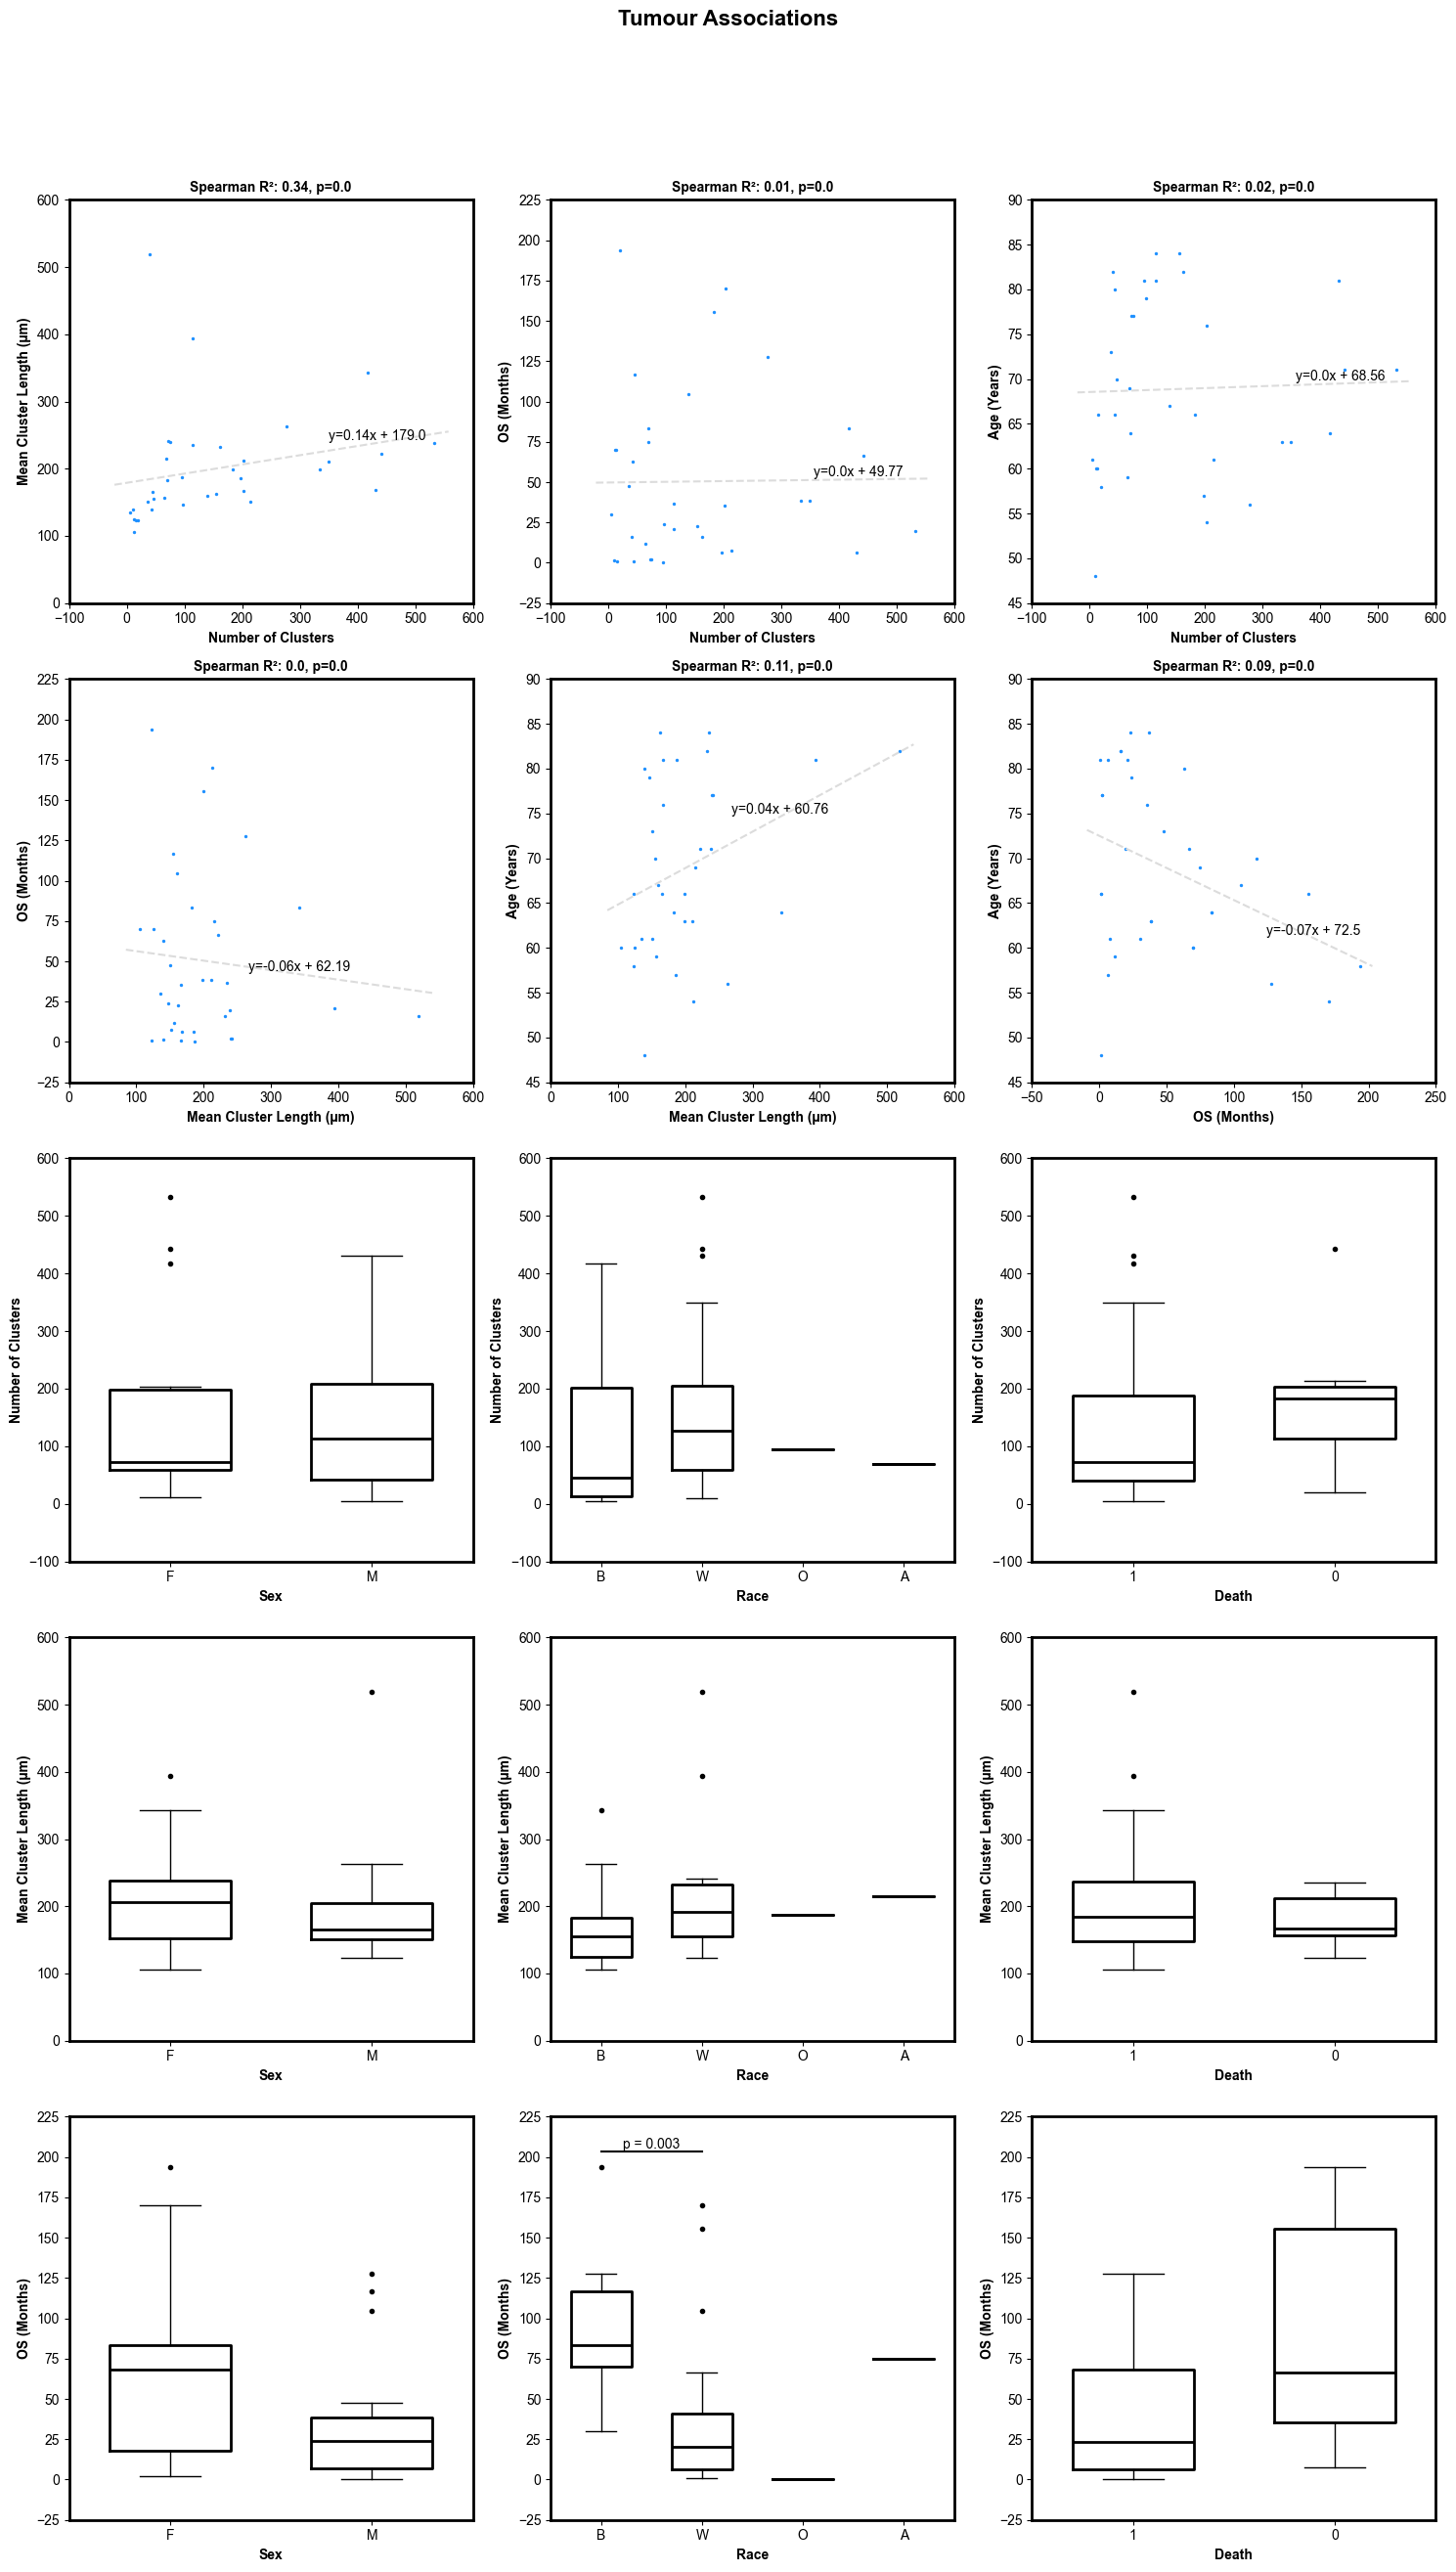

In [130]:
fig, axes = plt.subplots(5, 3, figsize=(15, 25))

# Individual Correlations ====================================================
# n_clusters vs max_len
s_res = plot_correlation(summary_tum["n_clusters"], summary_tum["max_len"], axes[0,0])

axes[0,0].set_xlabel("Number of Clusters", fontdict=font_dict)
axes[0,0].set_ylabel("Mean Cluster Length (\u00b5m)", fontdict=font_dict)

axes[0,0].set_title(f"Spearman R\u00b2: {round(s_res.statistic**2, 2)}, p={round(res.pvalue, 3)}", fontdict=font_dict)

# n_clusters vs OS
s_res = plot_correlation(summary_tum["n_clusters"], summary_tum["OS"], axes[0,1])

axes[0,1].set_xlabel("Number of Clusters", fontdict=font_dict)
axes[0,1].set_ylabel("OS (Months)", fontdict=font_dict)

axes[0,1].set_title(f"Spearman R\u00b2: {round(s_res.statistic**2, 2)}, p={round(res.pvalue, 3)}", fontdict=font_dict)

# n_clusters vs Age
s_res = plot_correlation(summary_tum["n_clusters"], summary_tum["Age"], axes[0,2])

axes[0,2].set_xlabel("Number of Clusters", fontdict=font_dict)
axes[0,2].set_ylabel("Age (Years)", fontdict=font_dict)

axes[0,2].set_title(f"Spearman R\u00b2: {round(s_res.statistic**2, 2)}, p={round(res.pvalue, 3)}", fontdict=font_dict)

# Max len vs OS
s_res = plot_correlation(summary_tum["max_len"], summary_tum["OS"], axes[1,0])

axes[1,0].set_xlabel("Mean Cluster Length (\u00b5m)", fontdict=font_dict)
axes[1,0].set_ylabel("OS (Months)", fontdict=font_dict)

axes[1,0].set_title(f"Spearman R\u00b2: {round(s_res.statistic**2, 2)}, p={round(res.pvalue, 3)}", fontdict=font_dict)

# Max len vs Age
s_res = plot_correlation(summary_tum["max_len"], summary_tum["Age"], axes[1,1])

axes[1,1].set_xlabel("Mean Cluster Length (\u00b5m)", fontdict=font_dict)
axes[1,1].set_ylabel("Age (Years)", fontdict=font_dict)

axes[1,1].set_title(f"Spearman R\u00b2: {round(s_res.statistic**2, 2)}, p={round(res.pvalue, 3)}", fontdict=font_dict)

# OS vs Age
s_res = plot_correlation(summary_tum["OS"], summary_tum["Age"], axes[1,2])

axes[1,2].set_xlabel("OS (Months)", fontdict=font_dict)
axes[1,2].set_ylabel("Age (Years)", fontdict=font_dict)

axes[1,2].set_title(f"Spearman R\u00b2: {round(s_res.statistic**2, 2)}, p={round(res.pvalue, 3)}", fontdict=font_dict)

# =====================================================================

# Individual Boxplots =======================================================

# n_clusters by Sex
plot_boxes(summary_tum, "Sex", "n_clusters", axes[2,0])

axes[2,0].set_xlabel("Sex", fontdict=font_dict)
axes[2,0].set_ylabel("Number of Clusters", fontdict=font_dict)

# n_clusters by Race
plot_boxes(summary_tum, "Race", "n_clusters", axes[2,1])

axes[2,1].set_xlabel("Race", fontdict=font_dict)
axes[2,1].set_ylabel("Number of Clusters", fontdict=font_dict)

# n_clusters by Age
plot_boxes(summary_tum, "Death", "n_clusters", axes[2,2])

axes[2,2].set_xlabel("Death", fontdict=font_dict)
axes[2,2].set_ylabel("Number of Clusters", fontdict=font_dict)

# max_len by Sex
plot_boxes(summary_tum, "Sex", "max_len", axes[3,0])

axes[3,0].set_xlabel("Sex", fontdict=font_dict)
axes[3,0].set_ylabel("Mean Cluster Length (\u00b5m)", fontdict=font_dict)

# max_len by Race
plot_boxes(summary_tum, "Race", "max_len", axes[3,1])

axes[3,1].set_xlabel("Race", fontdict=font_dict)
axes[3,1].set_ylabel("Mean Cluster Length (\u00b5m)", fontdict=font_dict)

# max_len by Age
plot_boxes(summary_tum, "Death", "max_len", axes[3,2])

axes[3,2].set_xlabel("Death", fontdict=font_dict)
axes[3,2].set_ylabel("Mean Cluster Length (\u00b5m)", fontdict=font_dict)

# OS by Sex
plot_boxes(summary_tum, "Sex", "OS", axes[4,0])

axes[4,0].set_xlabel("Sex", fontdict=font_dict)
axes[4,0].set_ylabel("OS (Months)", fontdict=font_dict)

# OS by Race
plot_boxes(summary_tum, "Race", "OS", axes[4,1])

axes[4,1].set_xlabel("Race", fontdict=font_dict)
axes[4,1].set_ylabel("OS (Months)", fontdict=font_dict)

# OS by Age
plot_boxes(summary_tum, "Death", "OS", axes[4,2])

axes[4,2].set_xlabel("Death", fontdict=font_dict)
axes[4,2].set_ylabel("OS (Months)", fontdict=font_dict)

# Overall plot
plt.suptitle("Tumour Associations", fontsize=16, fontweight="bold", fontname="Arial", y=1.05)

plt.tight_layout()

plt.savefig("../../../../Data/Plots/Survival/Ripley_tumour_associations.png", dpi=600, transparent=True, bbox_inches="tight")

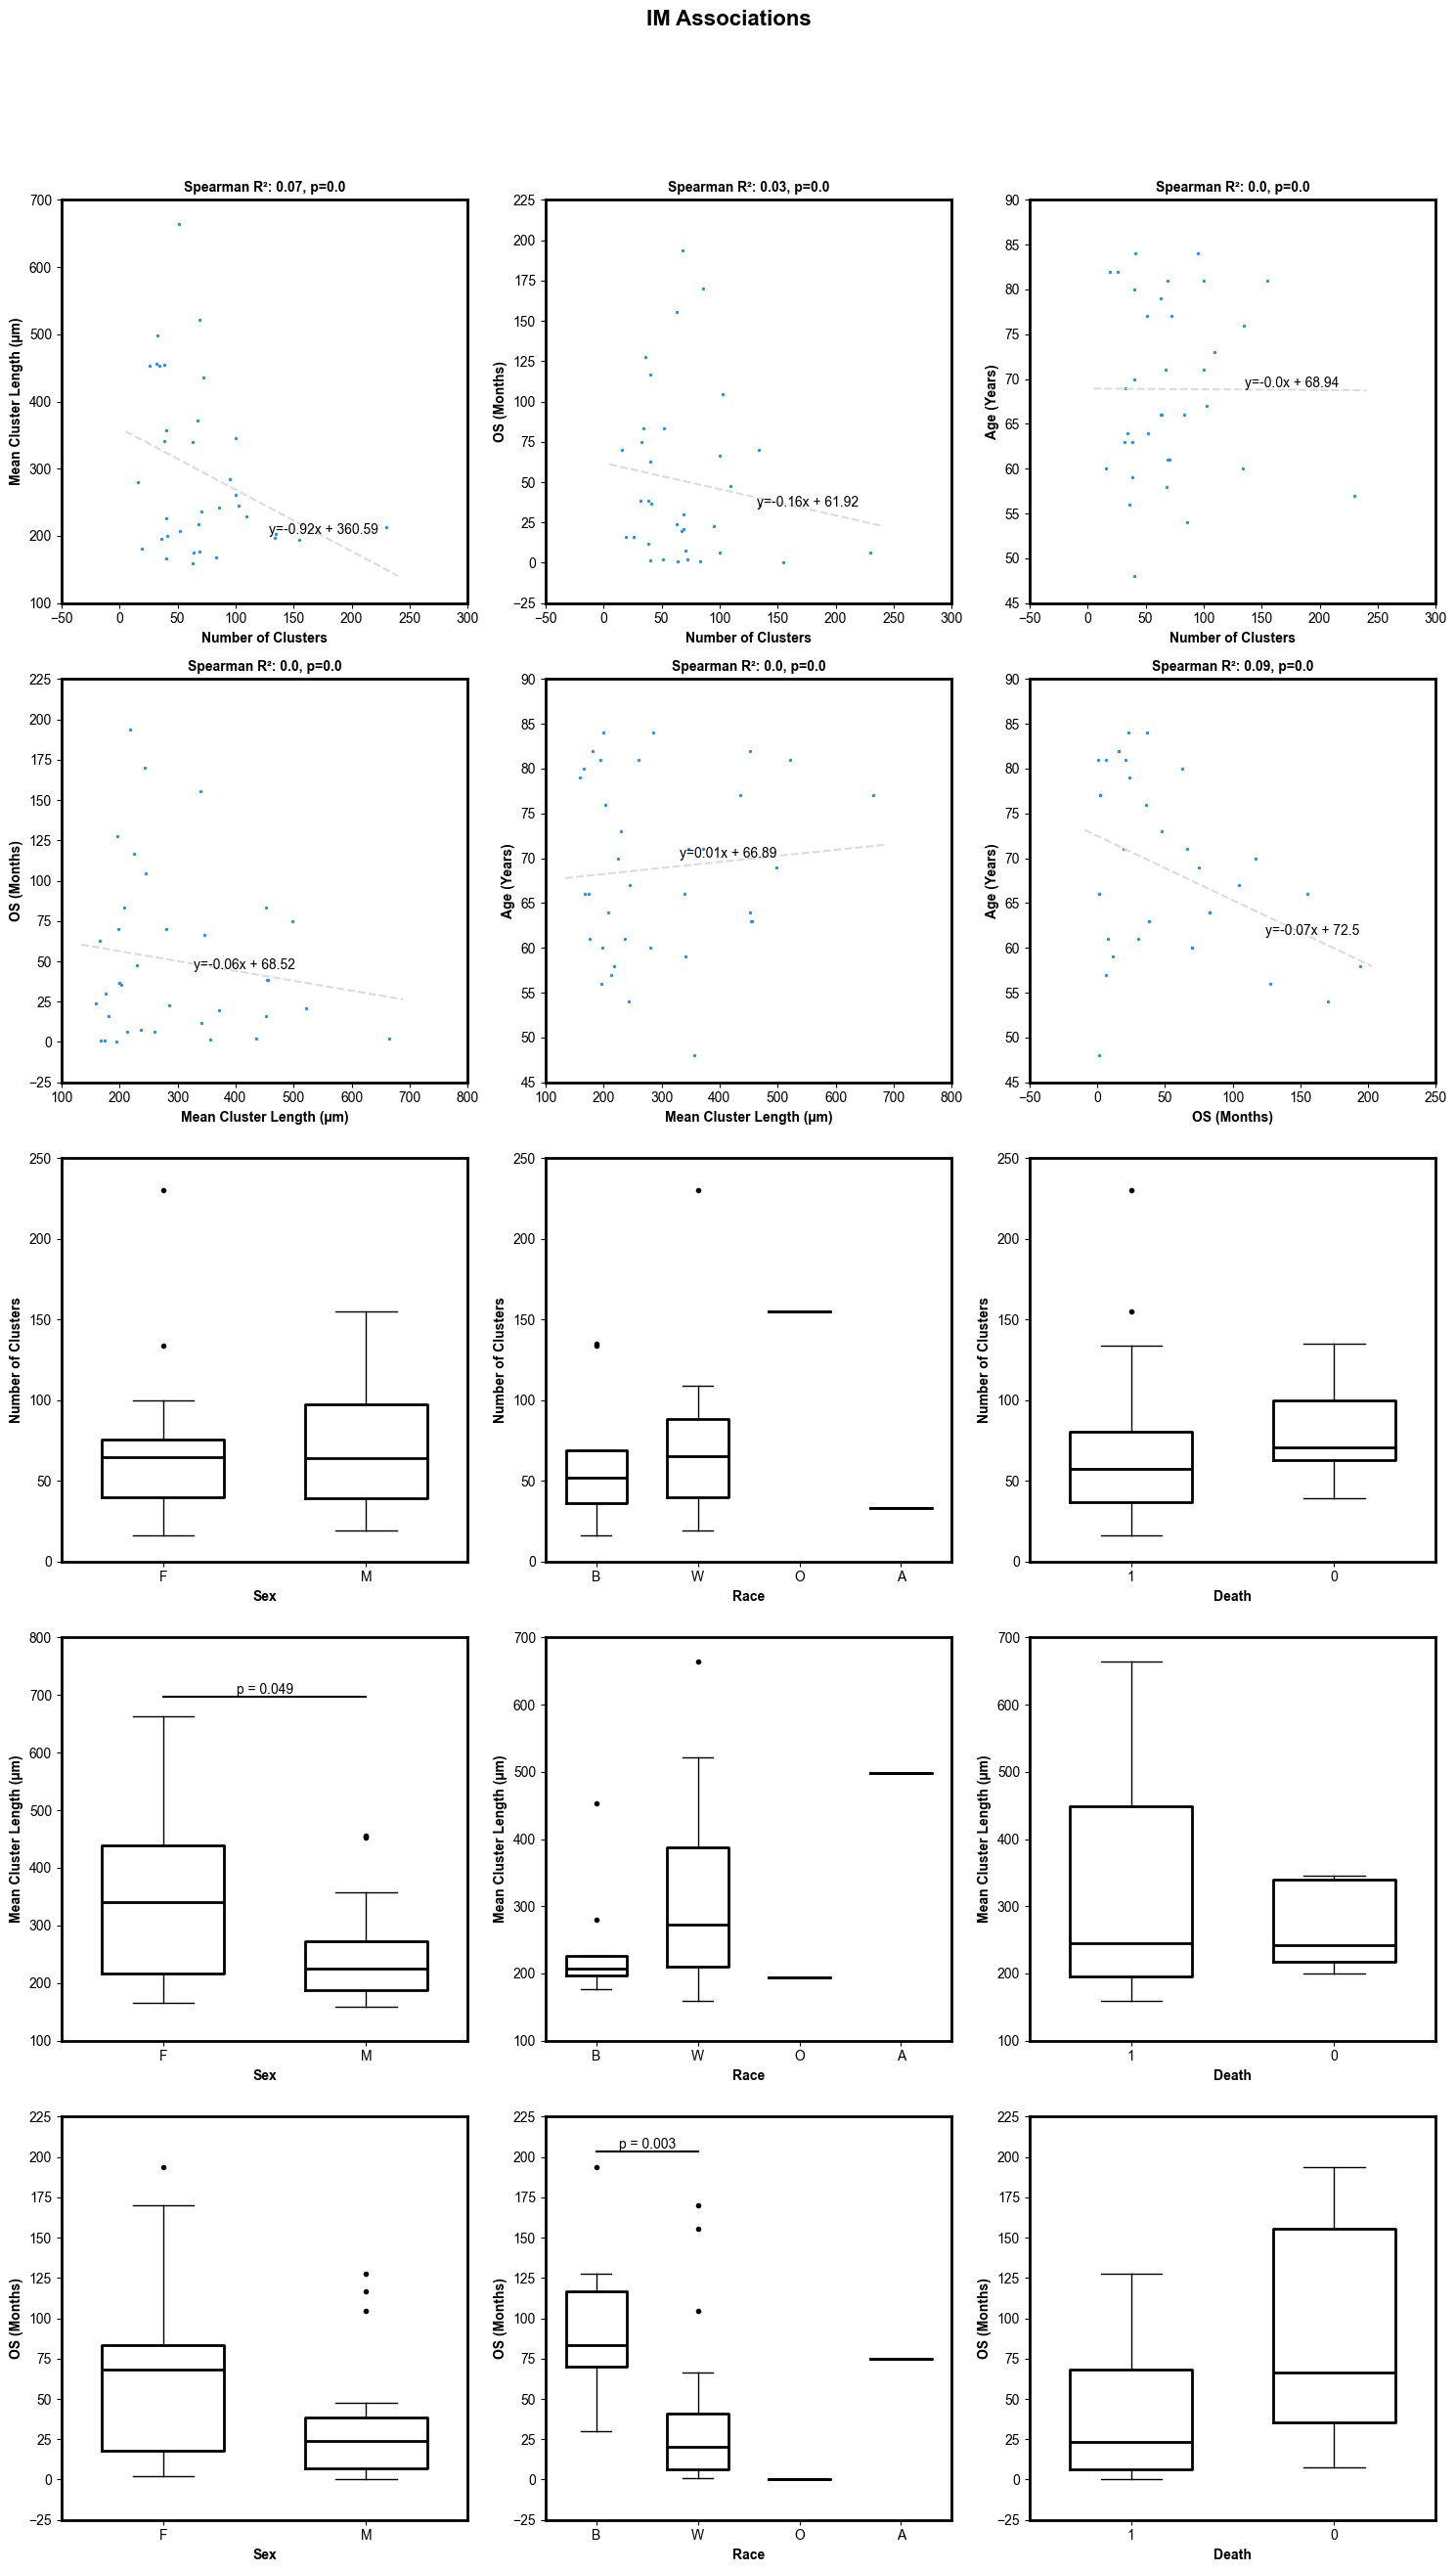

In [131]:
fig, axes = plt.subplots(5, 3, figsize=(15, 25))

# Individual Correlations ====================================================
# n_clusters vs max_len
s_res = plot_correlation(summary_im["n_clusters"], summary_im["max_len"], axes[0,0])

axes[0,0].set_xlabel("Number of Clusters", fontdict=font_dict)
axes[0,0].set_ylabel("Mean Cluster Length (\u00b5m)", fontdict=font_dict)

axes[0,0].set_title(f"Spearman R\u00b2: {round(s_res.statistic**2, 2)}, p={round(res.pvalue, 3)}", fontdict=font_dict)

# n_clusters vs OS
s_res = plot_correlation(summary_im["n_clusters"], summary_im["OS"], axes[0,1])

axes[0,1].set_xlabel("Number of Clusters", fontdict=font_dict)
axes[0,1].set_ylabel("OS (Months)", fontdict=font_dict)

axes[0,1].set_title(f"Spearman R\u00b2: {round(s_res.statistic**2, 2)}, p={round(res.pvalue, 3)}", fontdict=font_dict)

# n_clusters vs Age
s_res = plot_correlation(summary_im["n_clusters"], summary_im["Age"], axes[0,2])

axes[0,2].set_xlabel("Number of Clusters", fontdict=font_dict)
axes[0,2].set_ylabel("Age (Years)", fontdict=font_dict)

axes[0,2].set_title(f"Spearman R\u00b2: {round(s_res.statistic**2, 2)}, p={round(res.pvalue, 3)}", fontdict=font_dict)

# Max len vs OS
s_res = plot_correlation(summary_im["max_len"], summary_im["OS"], axes[1,0])

axes[1,0].set_xlabel("Mean Cluster Length (\u00b5m)", fontdict=font_dict)
axes[1,0].set_ylabel("OS (Months)", fontdict=font_dict)

axes[1,0].set_title(f"Spearman R\u00b2: {round(s_res.statistic**2, 2)}, p={round(res.pvalue, 3)}", fontdict=font_dict)

# Max len vs Age
s_res = plot_correlation(summary_im["max_len"], summary_im["Age"], axes[1,1])

axes[1,1].set_xlabel("Mean Cluster Length (\u00b5m)", fontdict=font_dict)
axes[1,1].set_ylabel("Age (Years)", fontdict=font_dict)

axes[1,1].set_title(f"Spearman R\u00b2: {round(s_res.statistic**2, 2)}, p={round(res.pvalue, 3)}", fontdict=font_dict)

# OS vs Age
s_res = plot_correlation(summary_im["OS"], summary_im["Age"], axes[1,2])

axes[1,2].set_xlabel("OS (Months)", fontdict=font_dict)
axes[1,2].set_ylabel("Age (Years)", fontdict=font_dict)

axes[1,2].set_title(f"Spearman R\u00b2: {round(s_res.statistic**2, 2)}, p={round(res.pvalue, 3)}", fontdict=font_dict)

# ===================================================================

# Individual Boxplots =======================================================

# n_clusters by Sex
plot_boxes(summary_im, "Sex", "n_clusters", axes[2,0])

axes[2,0].set_xlabel("Sex", fontdict=font_dict)
axes[2,0].set_ylabel("Number of Clusters", fontdict=font_dict)

# n_clusters by Race
plot_boxes(summary_im, "Race", "n_clusters", axes[2,1])

axes[2,1].set_xlabel("Race", fontdict=font_dict)
axes[2,1].set_ylabel("Number of Clusters", fontdict=font_dict)

# n_clusters by Age
plot_boxes(summary_im, "Death", "n_clusters", axes[2,2])

axes[2,2].set_xlabel("Death", fontdict=font_dict)
axes[2,2].set_ylabel("Number of Clusters", fontdict=font_dict)

# max_len by Sex
plot_boxes(summary_im, "Sex", "max_len", axes[3,0])

axes[3,0].set_xlabel("Sex", fontdict=font_dict)
axes[3,0].set_ylabel("Mean Cluster Length (\u00b5m)", fontdict=font_dict)

# max_len by Race
plot_boxes(summary_im, "Race", "max_len", axes[3,1])

axes[3,1].set_xlabel("Race", fontdict=font_dict)
axes[3,1].set_ylabel("Mean Cluster Length (\u00b5m)", fontdict=font_dict)

# max_len by Age
plot_boxes(summary_im, "Death", "max_len", axes[3,2])

axes[3,2].set_xlabel("Death", fontdict=font_dict)
axes[3,2].set_ylabel("Mean Cluster Length (\u00b5m)", fontdict=font_dict)

# OS by Sex
plot_boxes(summary_im, "Sex", "OS", axes[4,0])

axes[4,0].set_xlabel("Sex", fontdict=font_dict)
axes[4,0].set_ylabel("OS (Months)", fontdict=font_dict)

# OS by Race
plot_boxes(summary_im, "Race", "OS", axes[4,1])

axes[4,1].set_xlabel("Race", fontdict=font_dict)
axes[4,1].set_ylabel("OS (Months)", fontdict=font_dict)

# OS by Age
plot_boxes(summary_im, "Death", "OS", axes[4,2])

axes[4,2].set_xlabel("Death", fontdict=font_dict)
axes[4,2].set_ylabel("OS (Months)", fontdict=font_dict)

# Overall plot
plt.suptitle("IM Associations", fontsize=16, fontweight="bold", fontname="Arial", y=1.05)

plt.tight_layout()

plt.savefig("../../../../Data/Plots/Survival/Ripley_im_associations.png", dpi=600, transparent=True, bbox_inches="tight")

In [133]:
ws_stats

,sample,annotation,density,area_mm,hopkins,n_neighbour,Subject ID,OS,Death,Sex,Race,Age
0,01_F,tumour,804.022884,198.490619,0.536679,14.494250,1,83.225806,1,F,B,64
1,01_F,IM,815.782184,68.195900,0.542729,15.130418,1,83.225806,1,F,B,64
2,01_F,outer_IM,962.356591,25.719157,0.538139,14.607300,1,83.225806,1,F,B,64
3,01_G,tumour,225.027071,29.463122,0.564916,23.102434,1,83.225806,1,F,B,64
4,01_G,IM,212.653527,35.729480,0.607533,21.936455,1,83.225806,1,F,B,64
...,...,...,...,...,...,...,...,...,...,...,...,...
100,29_L,IM,310.231821,73.918916,0.565996,20.634262,29,47.806452,1,M,W,73
101,29_L,outer_IM,439.448216,46.328553,0.565720,19.221330,29,47.806452,1,M,W,73
102,30_D,tumour,122.400520,7.581667,0.582900,34.977897,30,1.266667,1,M,W,48
103,30_D,IM,673.056746,33.940675,0.569711,14.943522,30,1.266667,1,M,W,48


In [134]:
ws_tum = ws_stats[ws_stats["annotation"] == "tumour"].reset_index(drop=True)
ws_im = ws_stats[ws_stats["annotation"] == "outer_IM"].reset_index(drop=True)

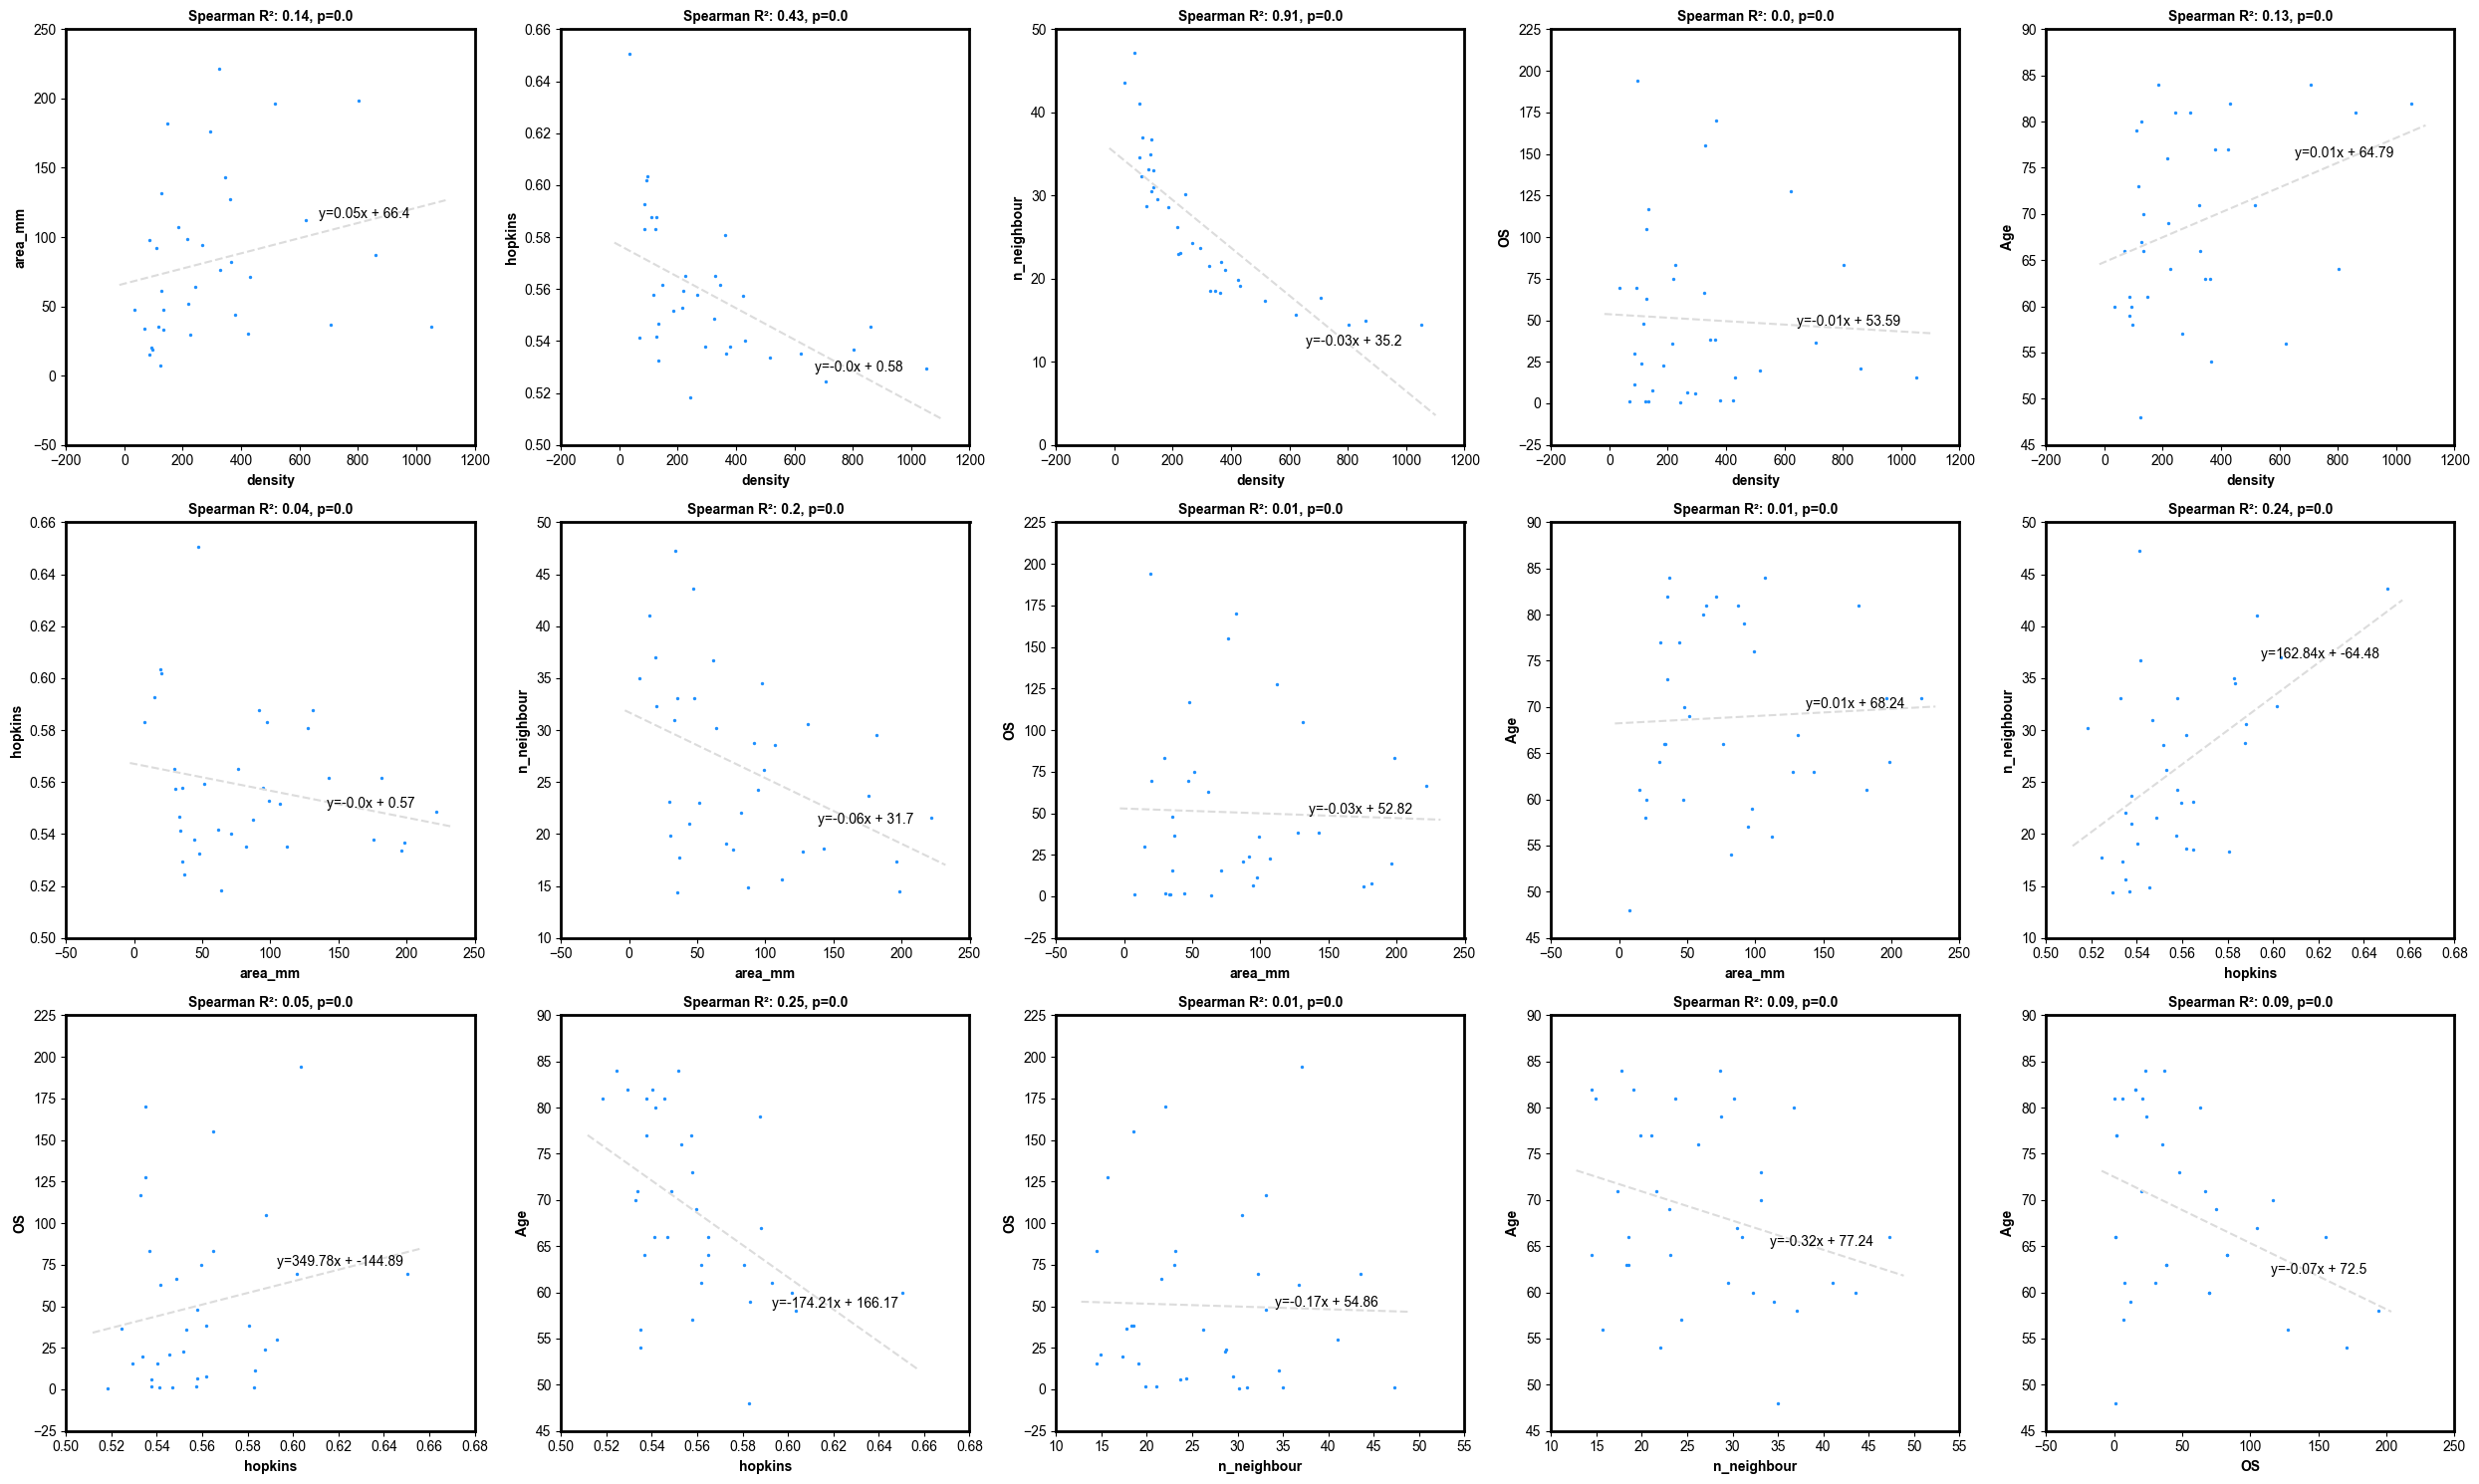

In [164]:
fig, axes = plt.subplots(3, 5, figsize=(25, 15))

# Individual Correlations ====================================================
for i, (x_var, y_var) in enumerate(itertools.combinations(["density", "area_mm", "hopkins", "n_neighbour", "OS", "Age"], 2)):
    row, col = divmod(i, 5)
    
    s_res = plot_correlation(ws_tum[x_var], ws_tum[y_var], axes[row, col])

    axes[row, col].set_xlabel(x_var, fontdict=font_dict)
    axes[row, col].set_ylabel(y_var, fontdict=font_dict)

    axes[row, col].set_title(f"Spearman R\u00b2: {round(s_res.statistic**2, 2)}, p={round(res.pvalue, 3)}", fontdict=font_dict)

plt.tight_layout()

plt.savefig("../../../../Data/Plots/Survival/WS_tumour_associations.png", dpi=600, transparent=True, bbox_inches="tight")


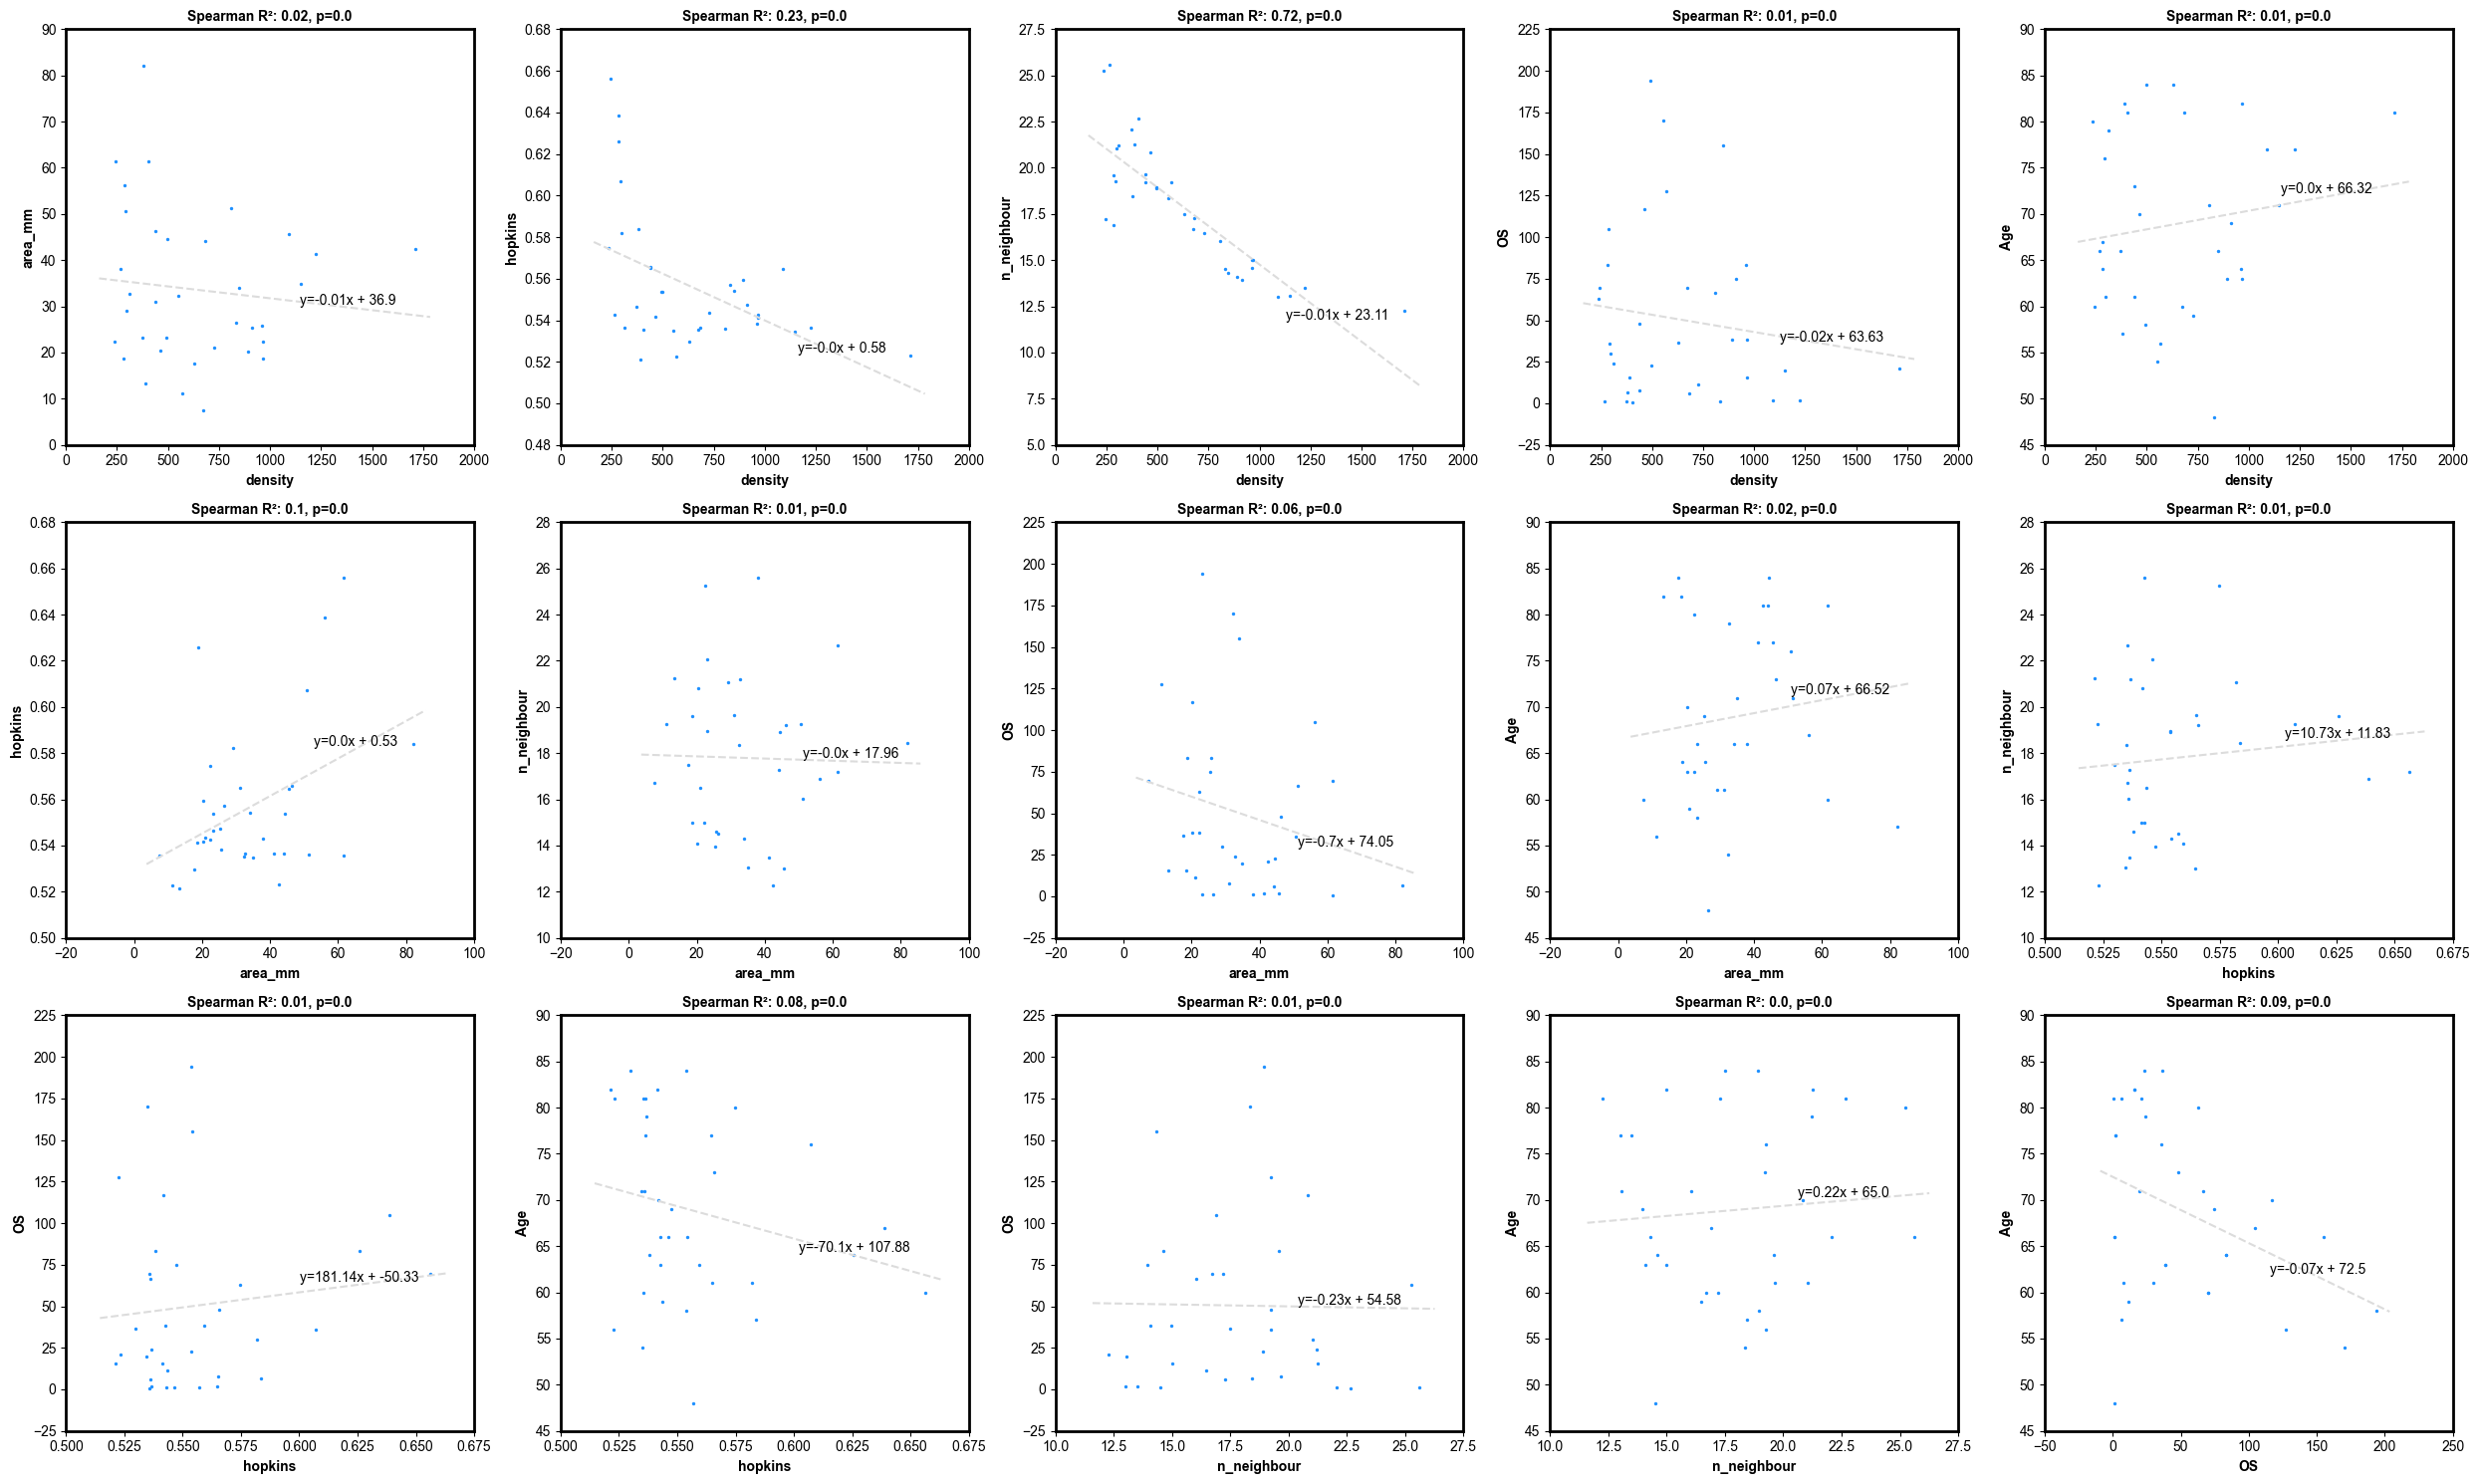

In [166]:
fig, axes = plt.subplots(3, 5, figsize=(25, 15))

# Individual Correlations ====================================================
for i, (x_var, y_var) in enumerate(itertools.combinations(["density", "area_mm", "hopkins", "n_neighbour", "OS", "Age"], 2)):
    row, col = divmod(i, 5)
    
    s_res = plot_correlation(ws_im[x_var], ws_im[y_var], axes[row, col])

    axes[row, col].set_xlabel(x_var, fontdict=font_dict)
    axes[row, col].set_ylabel(y_var, fontdict=font_dict)

    axes[row, col].set_title(f"Spearman R\u00b2: {round(s_res.statistic**2, 2)}, p={round(res.pvalue, 3)}", fontdict=font_dict)

plt.tight_layout()

plt.savefig("../../../../Data/Plots/Survival/WS_im_associations.png", dpi=600, transparent=True, bbox_inches="tight")